# Transformers From Scratch

## References

* https://arxiv.org/abs/1706.03762 (Attention is all you need)
* https://www.youtube.com/watch?v=eMlx5fFNoYc (3Blue1Brown)
* https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html (Sebastian Raschka)


## Architecture

![transformers](./images/Arch_Transformers.png)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

## Embedding

* Creating dummy encodings here to replicate the effect of any embedding model.
* We can pick any pretrained embedding model (word2vec, bert etc.) to get word vectors.
* Idea is to get vector representation of each word with comparable information in a mathematical plane.



### Tokenization

Sentence - `I am new to NLP with Deep Learning.`

Convinient Lie - `I|am|new|to|NLP|with|Deep|Learning|.`

Actual Truth - `I |am |new to| NLP |with |Deep |Learn|ing.`

In [2]:
paragraph = """I am new to NLP with deep learning. I like Deep Learning and I like NLP. I am trying to combine it."""

conversion = """Je suis nouveau en PNL avec l'apprentissage profond. J'aime le Deep Learning et j'aime la PNL. J'essaie de le combiner."""

bow = paragraph.lower().replace(".", "").split(" ") + \
    conversion.lower().replace(".", "").split(" ")

vocab = set(bow)

In [3]:
tokenizer = {val: idx for idx, val in enumerate(vocab)}

In [4]:
def sentence_separator(sentence):
    return sentence.lower().replace(".", "").split(" ")


def get_tokens(sentence):
    sentence_sep = sentence_separator(sentence)
    tokens = torch.Tensor([tokenizer[i] for i in sentence_sep]).type(torch.int32)
    return tokens


def get_embedding(tokens, dim=30):
    torch.manual_seed(123)
    embed = torch.nn.Embedding(len(vocab), dim)
    embedded_sentence = embed(tokens).detach()
    return embedded_sentence

In [5]:
sentence = "I like NLP"
tokens = get_tokens(sentence)
tokens

tensor([ 8,  4, 11], dtype=torch.int32)

In [6]:
get_embedding(tokens, dim=10)

tensor([[ 0.2553, -0.5496,  1.0042,  0.8272, -0.3948,  0.4892, -0.2168, -1.7472,
         -1.6025, -1.0764],
        [ 0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850,
          0.8768,  1.6221],
        [-0.9896,  0.7016, -0.9405, -0.4681,  1.0322, -0.2830,  0.4928, -0.0141,
         -0.2747, -0.7641]])

## Positional Encoding

\begin{align*}
PE(pos, 2i) &= \sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) \\ \\
PE(pos, 2i + 1) &= \cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})
\end{align*}

* Single value of $i \in [0, d_{model})$ map both sine and cosine function
* values will reside in -1 and 1
* 10000 is a scaling value

In [7]:
def positional_encoding(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens)
    for i in range(int(d_model / 2)):
        denominator = math.pow(scale, (2 * i) / d_model)
        p[positions, 2 * i] = torch.sin(positions / denominator)
        p[positions, (2 * i) + 1] = torch.cos(positions / denominator)
    return p

positional_encoding(5, 5)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [ 0.8415,  0.5403,  0.0251,  0.9997,  0.0000],
        [ 0.9093, -0.4161,  0.0502,  0.9987,  0.0000],
        [ 0.1411, -0.9900,  0.0753,  0.9972,  0.0000],
        [-0.7568, -0.6536,  0.1003,  0.9950,  0.0000]])

In [8]:
def positional_encoding_opt(n_tokens, d_model, scale=10_000):
    """
    * Rows - Positions (sentence length, number of tokens in input sentence)
    * Columns - Dimensions (Dimensions of embedding or models)
    """
    p = torch.zeros((n_tokens, d_model))
    positions = torch.arange(n_tokens).unsqueeze(1)
    denominator = 1 / torch.pow(scale, torch.arange(0, d_model, 2).unsqueeze(0) / d_model)
    if d_model % 2 == 0:
        end_idx = denominator.shape[1]
    else:
        end_idx = denominator.shape[1] - 1

    p[:, 0::2] = torch.sin(positions * denominator)
    p[:, 1::2] = torch.cos(positions * denominator[:, :end_idx])
    return p


positional_encoding_opt(5, 5)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  2.5116e-02,  9.9968e-01,  6.3096e-04],
        [ 9.0930e-01, -4.1615e-01,  5.0217e-02,  9.9874e-01,  1.2619e-03],
        [ 1.4112e-01, -9.8999e-01,  7.5285e-02,  9.9716e-01,  1.8929e-03],
        [-7.5680e-01, -6.5364e-01,  1.0031e-01,  9.9496e-01,  2.5238e-03]])

In [9]:
pd.DataFrame(
    positional_encoding_opt(4, 4, 100),
    columns=[f"dim {i}" for i in range(4)],
    index=[f"pos {i}" for i in range(4)],
)

,dim 0,dim 1,dim 2,dim 3
pos 0,0.000000,1.000000,0.000000,1.000000
pos 1,0.841471,0.540302,0.099833,0.995004
pos 2,0.909297,-0.416147,0.198669,0.980067
pos 3,0.141120,-0.989992,0.295520,0.955337


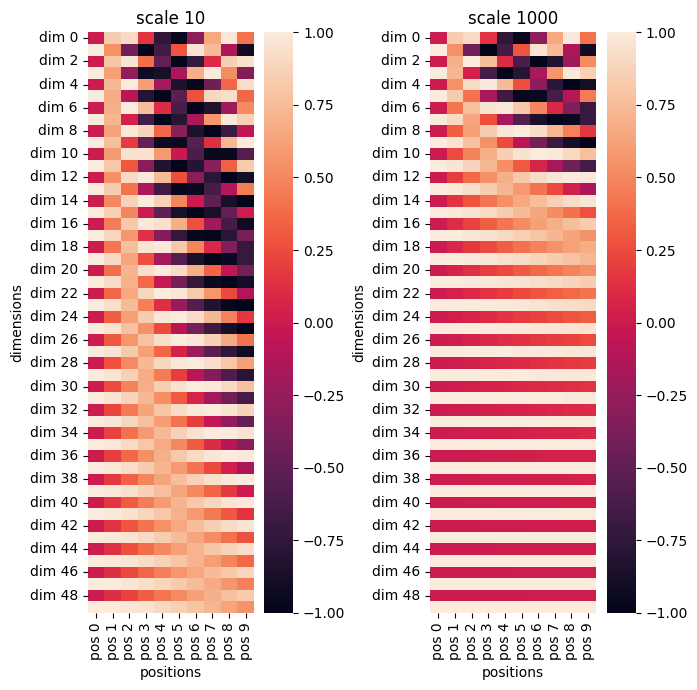

In [10]:
d_model = 50
n_tokens = 10


fig, ax = plt.subplots(1, 2, figsize=(7, 7))
pe = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=10)
sns.heatmap(
    pd.DataFrame(
        pe,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[0],
)
ax[0].set_title("scale 10")
ax[0].set_ylabel("dimensions")
ax[0].set_xlabel("positions")

pe = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=1000)
sns.heatmap(
    pd.DataFrame(
        pe,
        columns=[f"dim {i}" for i in range(d_model)],
        index=[f"pos {i}" for i in range(n_tokens)],
    ).T,
    vmin=-1,
    vmax=1,
    ax=ax[1],
)
ax[1].set_title("scale 1000")
ax[1].set_ylabel("dimensions")
ax[1].set_xlabel("positions")

plt.tight_layout()
plt.show()

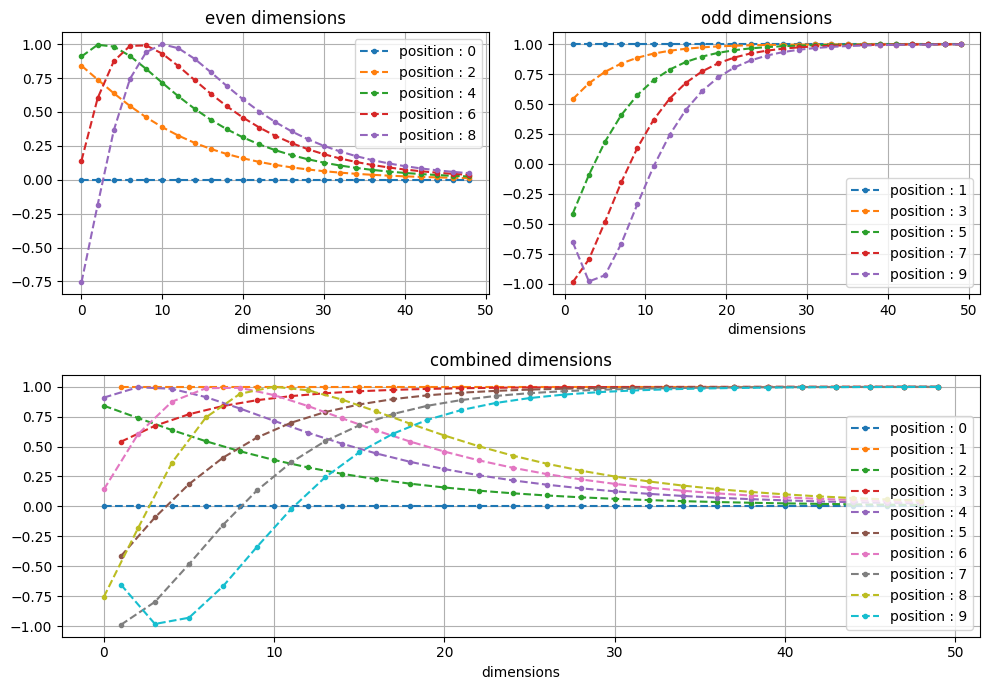

In [11]:
d_model = 50
n_tokens = 5
pe = positional_encoding_opt(d_model=d_model, n_tokens=n_tokens, scale=100)

fig = plt.figure(figsize=(10, 7))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, (3, 4))
for i in range(n_tokens):
    ax1.plot(np.arange(0, d_model, 2), pe[i, 0::2], ".--", label=f"position : {2 * i}")
    ax2.plot(
        np.arange(1, d_model, 2), pe[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

for i in range(n_tokens):
    ax3.plot(np.arange(0, d_model, 2), pe[i, 0::2], ".--", label=f"position : {2 * i}")
    ax3.plot(
        np.arange(1, d_model, 2), pe[i, 1::2], ".--", label=f"position : {2*i + 1}"
    )

ax1.legend()
ax1.grid()
ax1.set_title("even dimensions")
ax1.set_xlabel("dimensions")

ax2.legend()
ax2.grid()
ax2.set_title("odd dimensions")
ax2.set_xlabel("dimensions")

ax3.legend(loc="best")
ax3.grid()
ax3.set_title("combined dimensions")
ax3.set_xlabel("dimensions")

plt.tight_layout()
plt.show()

## Embedding + Positional Encoding

In [12]:
# sentence = "I am new to NLP with deep learning."
sentence = paragraph
tokens = get_tokens(sentence)

In [13]:
n_tokens = len(tokens)
d_model = 10

pe = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)
df = pd.DataFrame(
    pe,
    columns=[f"dim {i}" for i in range(pe.shape[1])],
    index=[f"pos {i}" for i in range(pe.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,8,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
pos 1,am,9,0.841471,0.540302,0.387674,0.921796,0.157827,0.987467,0.063054,0.998010,0.025116,0.999685
pos 2,new,20,0.909297,-0.416147,0.714713,0.699417,0.311697,0.950181,0.125857,0.992048,0.050217,0.998738
pos 3,to,18,0.141120,-0.989992,0.929966,0.367644,0.457755,0.889079,0.188159,0.982139,0.075285,0.997162
pos 4,nlp,11,-0.756802,-0.653644,0.999766,-0.021631,0.592338,0.805690,0.249712,0.968320,0.100306,0.994957
pos 5,with,1,-0.958924,0.283662,0.913195,-0.407523,0.712073,0.702105,0.310272,0.950648,0.125264,0.992123
pos 6,deep,10,-0.279415,0.960170,0.683794,-0.729675,0.813960,0.580922,0.369596,0.929192,0.150143,0.988664
pos 7,learning,0,0.656987,0.753902,0.347443,-0.937701,0.895443,0.445176,0.427450,0.904039,0.174927,0.984581
pos 8,i,8,0.989358,-0.145500,-0.043251,-0.999064,0.954481,0.298272,0.483602,0.875288,0.199601,0.979877
pos 9,like,4,0.412118,-0.911130,-0.427180,-0.904167,0.989594,0.143891,0.537830,0.843053,0.224149,0.974555


In [14]:
embeddings = get_embedding(tokens, dim=d_model)

In [15]:
df = pd.DataFrame(
    embeddings,
    columns=[f"dim {i}" for i in range(embeddings.shape[1])],
    index=[f"pos {i}" for i in range(embeddings.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,8,0.255292,-0.549628,1.004226,0.827231,-0.394809,0.489228,-0.216815,-1.747164,-1.602508,-1.076385
pos 1,am,9,0.903148,-0.721844,-0.595084,-0.711218,0.622965,-1.372882,-2.214989,-1.319310,-2.091499,0.962852
pos 2,new,20,1.172068,-0.437163,-0.405275,0.708644,0.953313,-0.013035,-0.130088,-0.087660,-0.067349,0.246739
pos 3,to,18,0.680502,1.206424,1.624970,0.345949,0.134253,0.766231,2.276040,-1.325529,-0.897015,0.113177
pos 4,nlp,11,-0.989555,0.701609,-0.940528,-0.468064,1.032201,-0.283002,0.492753,-0.014078,-0.274663,-0.764091
pos 5,with,1,0.698352,-1.409723,0.179380,1.895148,0.495446,0.269199,-0.077020,-1.020472,-0.168956,0.917765
pos 6,deep,10,-0.031861,-0.478956,0.766809,0.027468,1.992898,1.370847,-0.500868,-0.279276,-2.062818,0.006375
pos 7,learning,0,0.337370,-0.177777,-0.303528,-0.588012,0.348605,0.660341,-0.219638,-0.379170,0.767107,-1.192502
pos 8,i,8,0.255292,-0.549628,1.004226,0.827231,-0.394809,0.489228,-0.216815,-1.747164,-1.602508,-1.076385
pos 9,like,4,0.880544,1.554159,0.626616,-0.175487,0.098284,-0.093507,0.266215,-0.585036,0.876837,1.622144


In [16]:
combined_emb = pe + embeddings
combined_emb

df = pd.DataFrame(
    combined_emb,
    columns=[f"dim {i}" for i in range(combined_emb.shape[1])],
    index=[f"pos {i}" for i in range(combined_emb.shape[0])],
)
df.insert(0, column="token", value=tokens)
df.insert(0, column="word", value=sentence_separator(sentence))
df

,word,token,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,8,0.255292,0.450372,1.004226,1.827231,-0.394809,1.489228,-0.216815,-0.747164,-1.602508,-0.076385
pos 1,am,9,1.744619,-0.181542,-0.207410,0.210579,0.780792,-0.385415,-2.151936,-0.321300,-2.066383,1.962536
pos 2,new,20,2.081365,-0.853310,0.309439,1.408061,1.265010,0.937146,-0.004232,0.904388,-0.017133,1.245477
pos 3,to,18,0.821622,0.216431,2.554936,0.713594,0.592007,1.655309,2.464199,-0.343390,-0.821730,1.110339
pos 4,nlp,11,-1.746357,0.047966,0.059238,-0.489695,1.624539,0.522688,0.742465,0.954242,-0.174356,0.230865
pos 5,with,1,-0.260572,-1.126061,1.092575,1.487625,1.207520,0.971304,0.233251,-0.069824,-0.043692,1.909888
pos 6,deep,10,-0.311277,0.481215,1.450603,-0.702207,2.806857,1.951769,-0.131272,0.649916,-1.912674,0.995039
pos 7,learning,0,0.994357,0.576125,0.043915,-1.525713,1.244048,1.105517,0.207812,0.524869,0.942034,-0.207921
pos 8,i,8,1.244651,-0.695128,0.960975,-0.171833,0.559672,0.787500,0.266788,-0.871877,-1.402907,-0.096508
pos 9,like,4,1.292663,0.643028,0.199436,-1.079654,1.087877,0.050384,0.804045,0.258018,1.100986,2.596699


## Attention (SingleHead)

![scaled-dot-product-attention](./images/Arch_ScaledDotProductAttention.png)

\begin{align*}
\text{Attention}(Q, K, V) &= \text{softmax}\big( \frac{Q K^T}{\sqrt{d_k}} \big)V \\ \\
Q &= W_Q. X  & q_i &= W_Q x_i \text{ where } i \in [1, T] \\ 
K &= W_K. X  & k_i &= W_K x_i \text{ where } i \in [1, T] \\ 
V &= W_V. X  & v_i &= W_V x_i \text{ where } i \in [1, T] \\ \\
\text{where } T &= \text{Number of tokens in the sentence}
\end{align*}

* 2 sentences 
    * I want this to be a fair game
    * I want to go to a fair
* In these sentences word `fair` has two meanings that changes with rest of the context.
* Below is the visual representation of $QK^T$ where the multiplication should result in comparably higher value while joining(multiplying) the query and keys vectors
    
    |.| I | want | this | to | be | a | fair | game |
    |-|-|-|-|-|-|-|-|-|
    | I |.|.|.|.|.|.|.|.|
    | want |.|.|.|.|.|.|.|.|
    | this |.|.|.|.|.|.|.|.|
    | to |.|o|.|.|.|.|.|.|
    | be |.|.|.|.|o|.|.|.|
    | a |.|.|.|.|.|.|.|.|
    | fair |.|.|.|.|.|.|O|O|
    | game |.|.|.|.|.|.|O|.|.


In [17]:
def softmax(x):
    if len(x.shape) == 1:
        x = x.view(1, -1)
    return x / torch.sum(x, axis=1).view(-1, 1)


softmax(torch.Tensor([1, 1, 1, 1])), softmax(torch.Tensor([[1, 1, 1, 1], [1, 2, 1, 4]]))

(tensor([[0.2500, 0.2500, 0.2500, 0.2500]]),
 tensor([[0.2500, 0.2500, 0.2500, 0.2500],
         [0.1250, 0.2500, 0.1250, 0.5000]]))

In [18]:
d_model = 30

sentence = "I am new to NLP with deep learning"

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model)

In [19]:
d_query, d_key, d_value = 24, 24, 28

W_Q = torch.rand(d_query, d_model, requires_grad=True)
W_K = torch.rand(d_key, d_model, requires_grad=True)
W_V = torch.rand(d_value, d_model, requires_grad=True)

In [20]:
Q = torch.matmul(X, W_Q.T)
K = torch.matmul(X, W_K.T)
V = torch.matmul(X, W_V.T)

Q.shape, K.shape, V.shape

(torch.Size([8, 24]), torch.Size([8, 24]), torch.Size([8, 28]))

<Axes: >

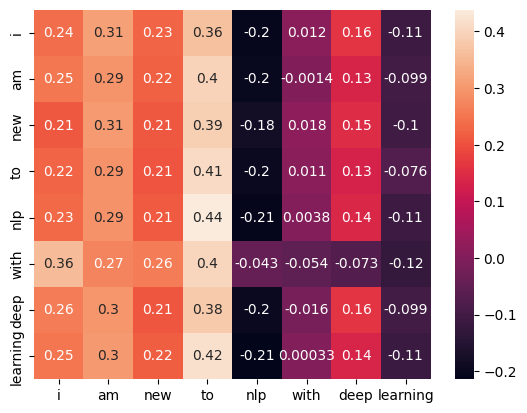

In [22]:
omega = softmax((Q @ K.T) / np.sqrt(d_key))

sns.heatmap(pd.DataFrame(
    omega.detach().numpy(),
    columns=sentence_separator(sentence),
    index=sentence_separator(sentence),
), annot=True)

In [23]:
def attention(Q, K, V, d_key):
    return softmax((Q @ K.T) / np.sqrt(d_key)) @ V

In [24]:
attn_out = attention(Q, K, V, d_key)

attn_out.shape

torch.Size([8, 28])

In [28]:
df = pd.DataFrame(
    attn_out.detach().numpy(),
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=sentence_separator(sentence),
)
df

,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,...,dim 18,dim 19,dim 20,dim 21,dim 22,dim 23,dim 24,dim 25,dim 26,dim 27
i,-4.532887,-6.150489,-5.631846,-4.351869,-4.267391,-4.307285,-5.150745,-3.657189,-7.058661,-3.265694,...,-5.656401,-4.648318,-5.726211,-4.951806,-5.558271,-4.304587,-5.250448,-5.380290,-3.886534,-3.795327
am,-4.642516,-6.276896,-5.664011,-4.364432,-4.406994,-4.304466,-5.248389,-3.656463,-7.103276,-3.386393,...,-5.662785,-4.858185,-5.704231,-5.003628,-5.463630,-4.250572,-5.284333,-5.295494,-3.817203,-3.729612
new,-4.545611,-5.983049,-5.466627,-4.274486,-4.282778,-4.192174,-5.149931,-3.503443,-6.929802,-3.205559,...,-5.462678,-4.626319,-5.598692,-4.844158,-5.403738,-4.279136,-5.043268,-5.271079,-3.882720,-3.583521
to,-4.659789,-6.081954,-5.555459,-4.277559,-4.374553,-4.164074,-5.229554,-3.471950,-6.998101,-3.303396,...,-5.501850,-4.769205,-5.579542,-4.860192,-5.312564,-4.332263,-5.057490,-5.274477,-3.784436,-3.538437
nlp,-4.935106,-6.486498,-5.843389,-4.600210,-4.589319,-4.366241,-5.418489,-3.683159,-7.398605,-3.455059,...,-5.723143,-5.077950,-5.992195,-5.090401,-5.613114,-4.542491,-5.296356,-5.506737,-4.028940,-3.713636
with,-3.923153,-5.848538,-4.737736,-3.414973,-4.459565,-4.358515,-5.153230,-3.683292,-6.083586,-3.617943,...,-5.378056,-5.113937,-4.443350,-5.064922,-4.609112,-2.683793,-5.459352,-3.741765,-3.194802,-3.624185
deep,-4.550518,-6.324923,-5.667882,-4.444787,-4.314960,-4.216207,-5.191046,-3.695875,-7.079109,-3.350593,...,-5.638992,-4.734217,-5.788167,-5.019212,-5.545519,-4.169921,-5.300307,-5.340770,-3.804523,-3.719588
learning,-4.866696,-6.513508,-5.870389,-4.566868,-4.552907,-4.396965,-5.436468,-3.747459,-7.417047,-3.491018,...,-5.824275,-5.058305,-5.973061,-5.161754,-5.656608,-4.520315,-5.411951,-5.493343,-4.022885,-3.836344


## Embedding + Positional Encoding + Attention

In [35]:
n_tokens = len(tokens)
d_model = 10

sentence = "I like NLP with deep learning."

tokens = get_tokens(sentence)
embeddings = get_embedding(tokens, dim=d_model)

In [36]:
pe = positional_encoding_opt(n_tokens=n_tokens, d_model=d_model, scale=100)

d_query, d_key, d_value = 10, 10, 10

W_Q = torch.rand(d_query, d_model, requires_grad=True)
W_K = torch.rand(d_key, d_model, requires_grad=True)
W_V = torch.rand(d_value, d_model, requires_grad=True)

In [37]:
combined_emb = pe + embeddings

In [38]:
Q = torch.matmul(combined_emb, W_Q.T)
K = torch.matmul(combined_emb, W_K.T)
V = torch.matmul(combined_emb, W_V.T)


attn_out = attention(Q, K, V, d_key)

df = pd.DataFrame(
    attn_out.detach().numpy(),
    columns=[f"dim {i}" for i in range(attn_out.shape[1])],
    index=[f"pos {i}" for i in range(attn_out.shape[0])],
)

df.insert(
    loc=0,
    column="word",
    value=sentence_separator(sentence),
)
df

,word,dim 0,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9
pos 0,i,2.824837,3.413080,3.233301,3.933438,4.479729,4.236826,3.066686,4.180108,3.253813,2.270339
pos 1,like,2.953650,3.559979,3.382294,3.971348,4.613080,4.332469,3.264371,4.506333,3.448966,2.378821
pos 2,nlp,2.947998,3.553496,3.364831,3.962696,4.593490,4.324551,3.254963,4.498837,3.443381,2.361825
pos 3,with,2.859584,3.453221,3.256241,3.931603,4.492039,4.254729,3.120970,4.281540,3.312153,2.279824
pos 4,deep,2.893579,3.491960,3.308558,3.948112,4.543667,4.281163,3.175982,4.361027,3.360323,2.325086
pos 5,learning,2.941271,3.542462,3.369556,3.950962,4.591857,4.296255,3.255300,4.486418,3.426831,2.376729


## MultiHead Attention

![multi-head-attention](./images/Arch_MultiHeadAttention.png)

In [39]:
d_model = 30
n_heads = 3

sentence = "I am new to NLP with deep learning"

tokens = get_tokens(sentence)
X = get_embedding(tokens, dim=d_model).repeat(n_heads, 1, 1)

In [40]:
X.shape

torch.Size([3, 8, 30])

In [42]:
d_query, d_key, d_value = 24, 24, 28

W_Q = torch.rand(n_heads, d_query, d_model, requires_grad=True)
W_K = torch.rand(n_heads, d_key, d_model, requires_grad=True)
W_V = torch.rand(n_heads, d_value, d_model, requires_grad=True)

In [43]:
X.shape, W_Q.shape

(torch.Size([3, 8, 30]), torch.Size([3, 24, 30]))

In [44]:
Q = torch.bmm(X, W_Q.transpose(1, 2))
K = torch.bmm(X, W_K.transpose(1, 2))
V = torch.bmm(X, W_V.transpose(1, 2))

Q.shape, K.shape, V.shape

(torch.Size([3, 8, 24]), torch.Size([3, 8, 24]), torch.Size([3, 8, 28]))

In [45]:
def multihead_attention(Q, K, V, d_key, n_heads):
    def multihead_softmax(x):
        if len(x.shape) == 1:
            x = x.view(n_heads, 1, -1)
        return x / torch.sum(x, axis=1).view(n_heads, -1, 1)
    
    return multihead_softmax((Q @ K.transpose(1, 2)) / np.sqrt(d_key)) @ V

In [46]:
multihead_attention(Q, K, V, d_key, n_heads).shape

torch.Size([3, 8, 28])

## Masked-MultiHead Attention

* mask the tokens that come in next steps (as -inf)
* so that softmax converts them to zero
* In cases of chatbot, the algorithm should not know the next word at the time of training
* so that it can predict the probability of next word based on target values and hadn't seen the value before